# Project: Analyzing the Impact of OPEC Crude Oil Production Quotas on Impact on Spot Prices (1983-2022)

In [13]:
# Install library requirements.
!pip install pandas numpy 

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [14]:
# Import library requirements.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

### Oil Production

In [15]:
# Importing oil production dataset.
world_oil_production_df = pd.read_csv("data/opec_upstream/world_oil_production.csv", index_col="Index")
world_oil_production_df.replace('na', np.nan, inplace=True)
world_oil_production_df = world_oil_production_df.astype(float)

# Replacing incorrectly labeled countries. 
replace = {'IR Iran': 'I.R.Iran', 'Saudi Arabia1': 'Saudi Arabia', 'Kuwait1': 'Kuwait', 'Syrian Arab Rep.': 'Syria', 'Uzbekistan`': 'Uzbekistan'}
world_oil_production_df = world_oil_production_df.rename(index=replace)

# Importing oil demand dataset. 
world_oil_demand_df = pd.read_csv("data/opec_downstream/world_oil_demand.csv", index_col="Index")
world_oil_demand_df.replace('na', np.nan, inplace=True)
world_oil_demand_df = world_oil_demand_df.astype(float)

# Merging oil production and oil demand datasets; One-to-one matching needed to compute oil deficit. 
world_oil_deficit_df = world_oil_demand_df.merge(world_oil_production_df, left_index=True, right_index=True, how='inner')

# Iterating over years of oil production and oil demand to compute oil deficit. 
for year in range(1960, 2023):
    year_x, year_y = f"{year}_x", f"{year}_y"
    world_oil_deficit_df[year] = world_oil_deficit_df[year_x] - world_oil_deficit_df[year_y]
    world_oil_deficit_df = world_oil_deficit_df.drop(columns=[year_x, year_y])
    
# Transposing DataFrames to set years as index.  
world_oil_production_df = world_oil_production_df.transpose()
world_oil_demand_df = world_oil_demand_df.transpose()
world_oil_deficit_df = world_oil_deficit_df.transpose()

# Converting year index to datetime object. 
world_oil_production_df.index = pd.to_datetime(world_oil_production_df.index, format='%Y')
world_oil_demand_df.index = pd.to_datetime(world_oil_demand_df.index, format='%Y')
world_oil_deficit_df.index = pd.to_datetime(world_oil_deficit_df.index, format='%Y')

# Filter the DataFrames to include data only within 1983 - 2022. 
world_oil_production_df = world_oil_production_df.loc['1983':'2022']
world_oil_demand_df = world_oil_demand_df.loc['1983':'2022']
world_oil_deficit_df = world_oil_deficit_df.loc['1983':'2022']

In [16]:
world_oil_deficit_df.head()

Index,Canada,Chile,Mexico,United States,United Kingdom,Australia,China,India,Indonesia,Malaysia,...,Angola,Congo,Egypt,Equatorial Guinea,Gabon,Libya,Nigeria,Russia,Azerbaijan,Kazakhstan
1983-01-01,332.090,60.679,-1371.093,7132.343,-738.536,214.830,-406.614,337.808,-786.285,-149.274,...,-140.500,-85.0,-357.337,0.0,-143.4,-992.059,-1042.5,-5892.018,NaN,-19.045
1984-01-01,250.144,60.760,-1289.817,7447.043,-680.840,156.798,-512.434,293.530,-825.806,-212.653,...,-184.000,-115.0,-383.891,0.0,-146.4,-856.600,-1210.0,-5933.147,NaN,-12.665
1985-01-01,275.597,63.019,-1154.800,7106.634,-915.066,95.967,-579.926,274.329,-703.140,-216.288,...,-200.637,-111.0,-479.992,0.0,-158.7,-876.745,-1320.9,-5750.783,NaN,-6.027
1986-01-01,401.367,70.745,-904.745,7879.870,-862.805,202.860,-572.123,326.148,-780.647,-278.027,...,-252.301,-114.0,-400.386,1.0,-150.7,-1188.000,-1286.6,-6009.721,NaN,-52.808
1987-01-01,369.179,78.353,-964.967,8590.025,-846.213,175.551,-554.233,392.896,-660.115,-251.068,...,-327.655,-121.0,-458.403,1.0,-142.5,-840.504,-1148.0,-6101.736,NaN,-72.424


In [17]:
# Function graphs oil production, oil demand and oil deficit for a given list of countries. 
def line_plot_function(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    world_oil_production_df[cols].plot(kind='line', legend=False, ax=ax1)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Oil (1000 b/d)')
    ax1.set_title('Production')

    world_oil_demand_df[cols].plot(kind='line', legend=False, ax=ax2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Oil (1000 b/d)')
    ax2.set_title('Demand')

    world_oil_deficit_df[cols].plot(kind='line', legend=False, ax=ax3)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Oil (1000 b/d)')
    ax3.set_title('Deficit')
    ax3.axhline(y=0, color='black', linestyle='--')

    lines, labels = ax1.get_legend_handles_labels()
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()

In [18]:
# Function plots the distributions of oil production, oil demand and oil deficit for a given list of countries. 
def box_plot_function(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Generating x-axis labels. 
    x_labels = list(world_oil_production_df.index.year)
    x_labels = [label if i % 5 == 0 else '' for i, label in enumerate(x_labels)]
    
    world_oil_production_df[cols].transpose().boxplot(ax=ax1, showfliers=False)
    ax1.set_title('Production')
    ax1.set_ylabel('Oil (1000 b/d)')
    ax1.grid(False, axis='x')
    ax1.set_xticklabels(x_labels)
    
    world_oil_demand_df[cols].transpose().boxplot(ax=ax2, showfliers=False)
    ax2.set_title('Demand')
    ax2.set_ylabel('Oil (1000 b/d)')
    ax2.grid(False, axis='x')
    ax2.set_xticklabels(x_labels)

    world_oil_deficit_df[cols].transpose().boxplot(ax=ax3, showfliers=False)  
    ax3.set_title('Deficit')
    ax3.set_ylabel('Oil (1000 b/d)')
    ax3.axhline(y=0, color='red', linestyle='--')
    ax3.grid(False, axis='x')
    ax3.set_xticklabels(x_labels)

    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()

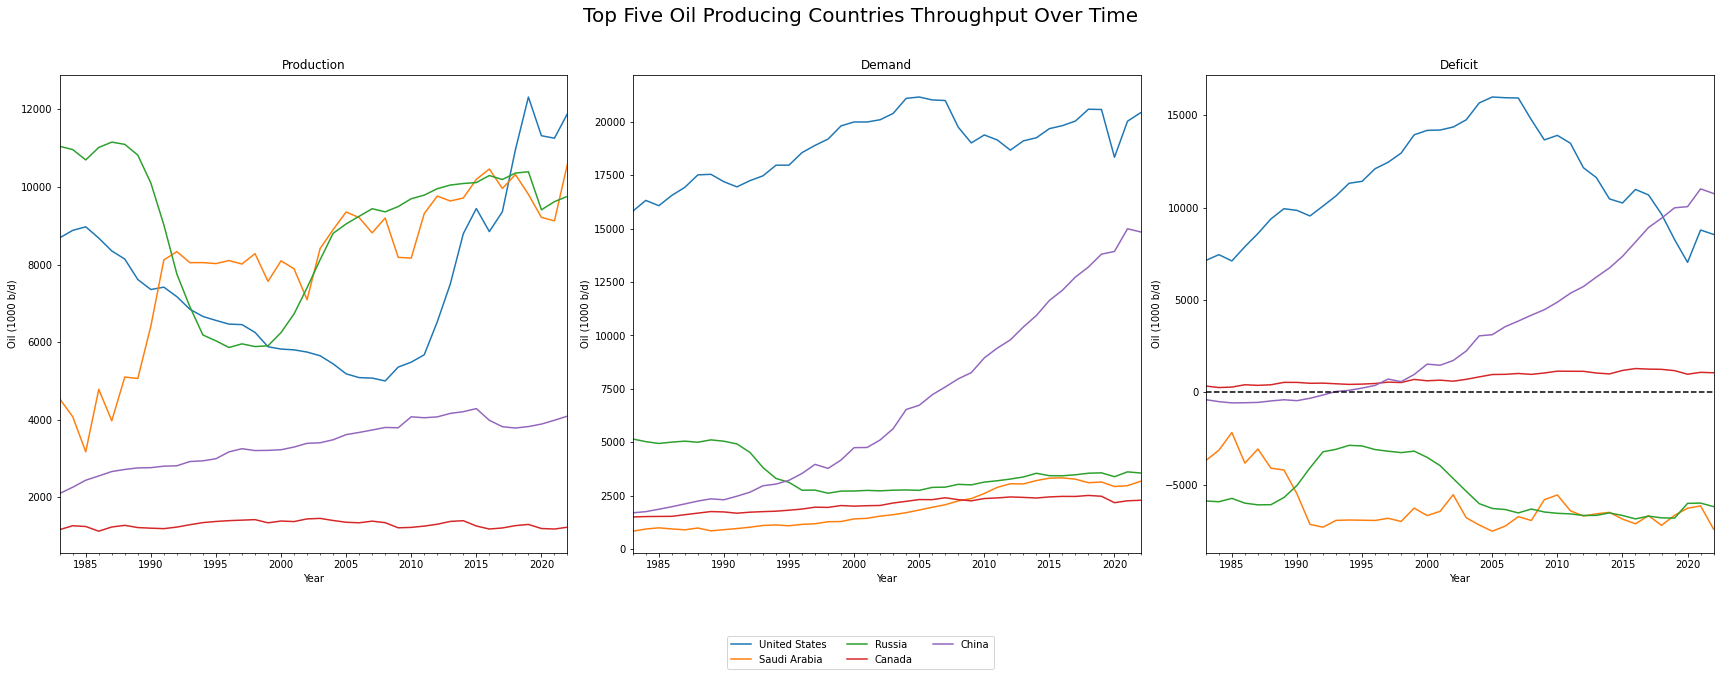

In [19]:
# List of the top 5 producers of oil in 2023.
top_5_producers = ['United States', 'Saudi Arabia', 'Russia', 'Canada', 'China']
line_plot_function(top_5_producers, title="Top Five Oil Producing Countries Throughput Over Time")

In [20]:
# List of OPEC countries in 2023. 
opec_countries = pd.read_csv('data/countries/opec.csv', header=None, squeeze=True)
opec_countries.head(13)

/var/folders/rq/9zvkr67d2mx07n6md37__xcr0000gn/T/ipykernel_92538/3424938140.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  opec_countries = pd.read_csv('data/countries/opec.csv', header=None, squeeze=True)


0                  Algeria
1                   Angola
2        Equatorial Guinea
3                    Gabon
4                 I.R.Iran
5                     Iraq
6                   Kuwait
7                    Libya
8                  Nigeria
9                    Congo
10            Saudi Arabia
11    United Arab Emirates
12               Venezuela
Name: 0, dtype: object

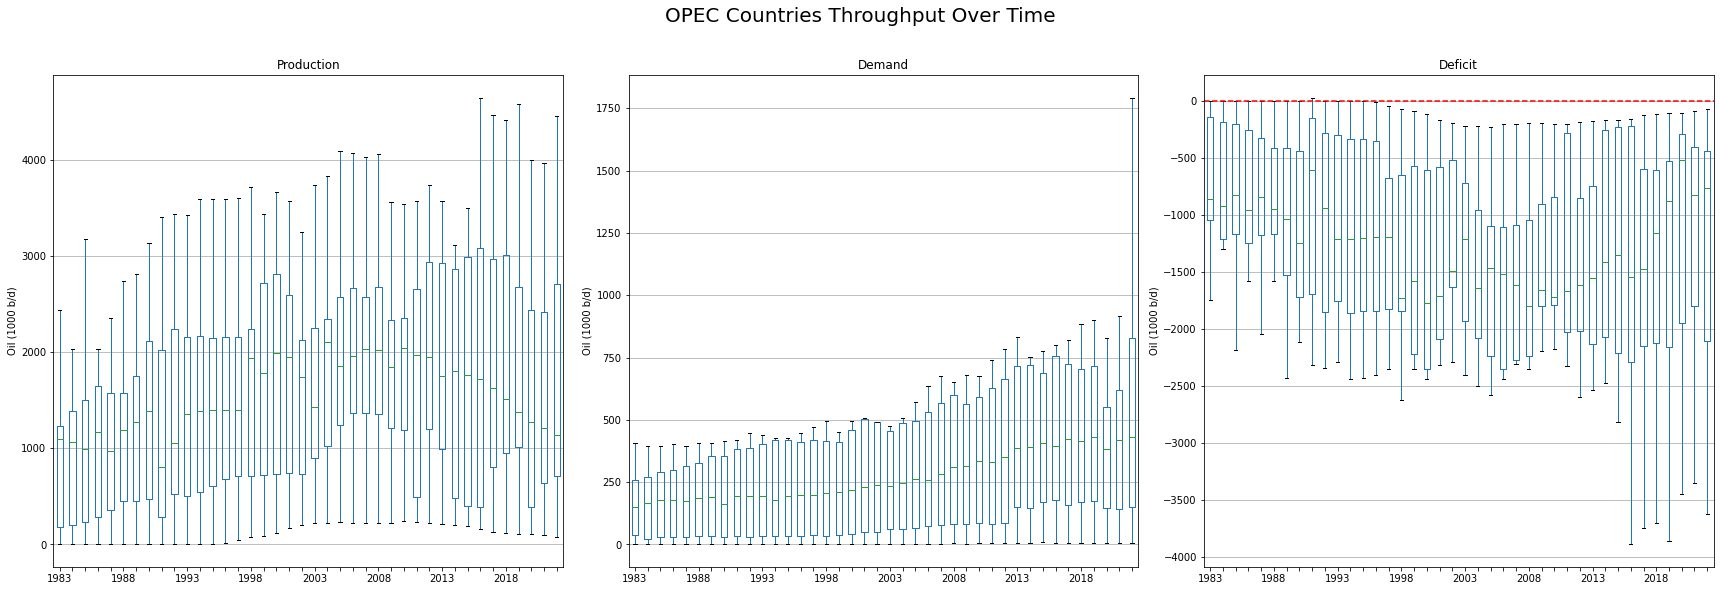

In [21]:
box_plot_function(opec_countries, title="OPEC Countries Throughput Over Time")

In [22]:
# List of OECD countries in 2023. 
oecd_countries = pd.read_csv('data/countries/oecd.csv', header=None, squeeze=True)
oecd_countries.head(10)

/var/folders/rq/9zvkr67d2mx07n6md37__xcr0000gn/T/ipykernel_92538/1980000306.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  oecd_countries = pd.read_csv('data/countries/oecd.csv', header=None, squeeze=True)


0         Australia
1           Austria
2           Belgium
3            Canada
4             Chile
5          Colombia
6    Czech Republic
7           Denmark
8           Estonia
9           Finland
Name: 0, dtype: object

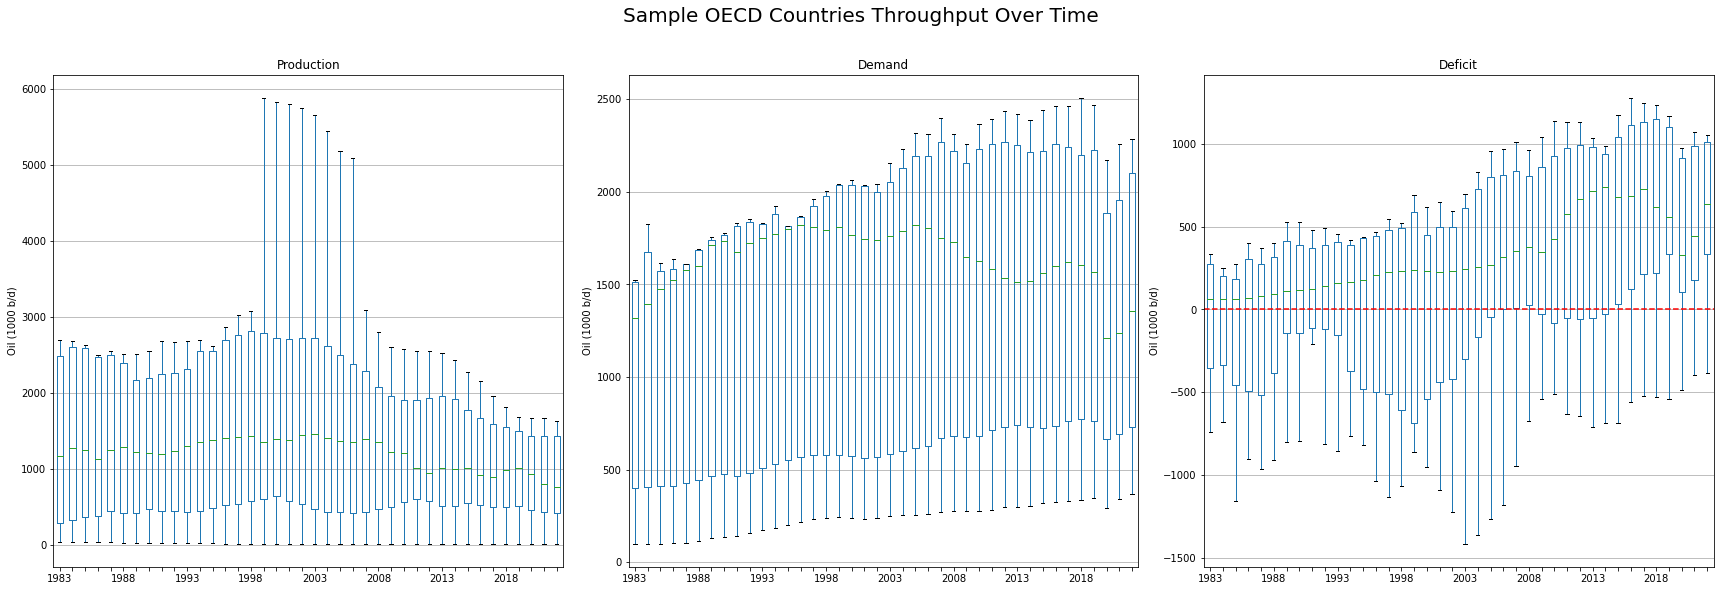

In [23]:
oecd_sample_countries = oecd_countries[oecd_countries.isin(world_oil_deficit_df.columns)]
box_plot_function(oecd_sample_countries, "Sample OECD Countries Throughput Over Time")

### Oil Prices

In [24]:
# Importing oil spot price dataset. 
oil_spot_prices_df = pd.read_csv("data/opec_prices/oil_spot_prices.csv", index_col="Index")
oil_spot_prices_df.replace('na', np.nan, inplace=True)
oil_spot_prices_df = oil_spot_prices_df.astype(float)

# Creating 2D index for countries with multiple oil benchmarks.  
oil_spot_prices_df.index = oil_spot_prices_df.index.str.split(' - ', expand=True)

# Replacing incorrectly labeled countries. 
oil_spot_prices_df = oil_spot_prices_df.rename(index={'IR Iran': 'I.R.Iran'})

# Transposing DataFrames to set years as index.  
oil_spot_prices_df = oil_spot_prices_df.transpose()

In [25]:
oil_spot_prices_df.head()

Algeria  Angola    Egypt   I.R.Iran Indonesia   Libya Malaysia        \
     Zarzaitine Cabinda Suez Mix Iran Light     Minas   Brega     Miri Tapis   
1983     30.398     NaN      NaN     28.145    28.981  29.740      NaN   NaN   
1984     29.087     NaN   27.197     26.810    27.962  28.879      NaN   NaN   
1985     27.925     NaN   25.870     26.034    25.990  27.789      NaN   NaN   
1986     14.832     NaN   12.619     13.501    13.415  14.313      NaN   NaN   
1987     18.095     NaN   16.748     17.027    17.779  17.675      NaN   NaN   

      Mexico          ...  Norway    Oman   Qatar  Russia Saudi Arabia  \
     Isthmus    Maya  ... Oseberg    Oman  Dukhan   Urals   Arab Heavy   
1983  28.817     NaN  ...     NaN  28.748  29.122     NaN       26.590   
1984  28.192     NaN  ...     NaN  28.019  28.018     NaN       26.681   
1985  26.858     NaN  ...     NaN  26.944  27.150     NaN       25.833   
1986  13.433     NaN  ...     NaN  13.288  13.458     NaN          NaN   
1987  17.809  15.261  ...     NaN  17.252  17.395  17.289       16.083   

     United Kingdom         United States United Arab Emirates    OPEC  
         BrentDated Forties           WTI                Dubai     ORB  
1983         29.715  29.572        30.413               28.180  29.037  
1984         28.715  28.586        29.393               27.522  28.204  
1985         27.533  27.472        27.960               26.491  27.007  
1986         14.274  14.182        14.913               12.956  13.533  
1987         18.406  18.270        19.164               16.916  17.725  

[5 rows x 22 columns]

In [35]:
# Function plots the spot prices of oil, z-score dist. of spot prices and the 10 year moving average of z-score dist. for given list of countries. 
def price_plot_function(cols, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    oil_spot_prices_df[cols].plot(kind='line', legend=False, ax=ax1)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Spot Price ($/d)')
    ax1.set_title('Spot Prices')
    ax3.axhline(y=0, color='black', linestyle='--')

    # Computing the z-score
    oil_spot_prices_norm = oil_spot_prices_df[cols].apply(zscore, axis=1)

    oil_spot_prices_norm.plot(kind='line', legend=False, ax=ax2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Spot Price (z-score)')
    ax2.set_title('Normalized Spot Prices')
    ax3.axhline(y=0, color='black', linestyle='--')

    # Computing moving average for normalized spot prices.   
    oil_spot_prices_ma = oil_spot_prices_norm.rolling(window=10, min_periods=5).mean()

    oil_spot_prices_ma.plot(kind='line', legend=False, ax=ax3)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Spot Price (z-score)')
    ax3.set_title('Normalized 10yr-MA Spot Prices ')
    ax3.axhline(y=0, color='black', linestyle='--')

    lines, labels = ax1.get_legend_handles_labels()
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    

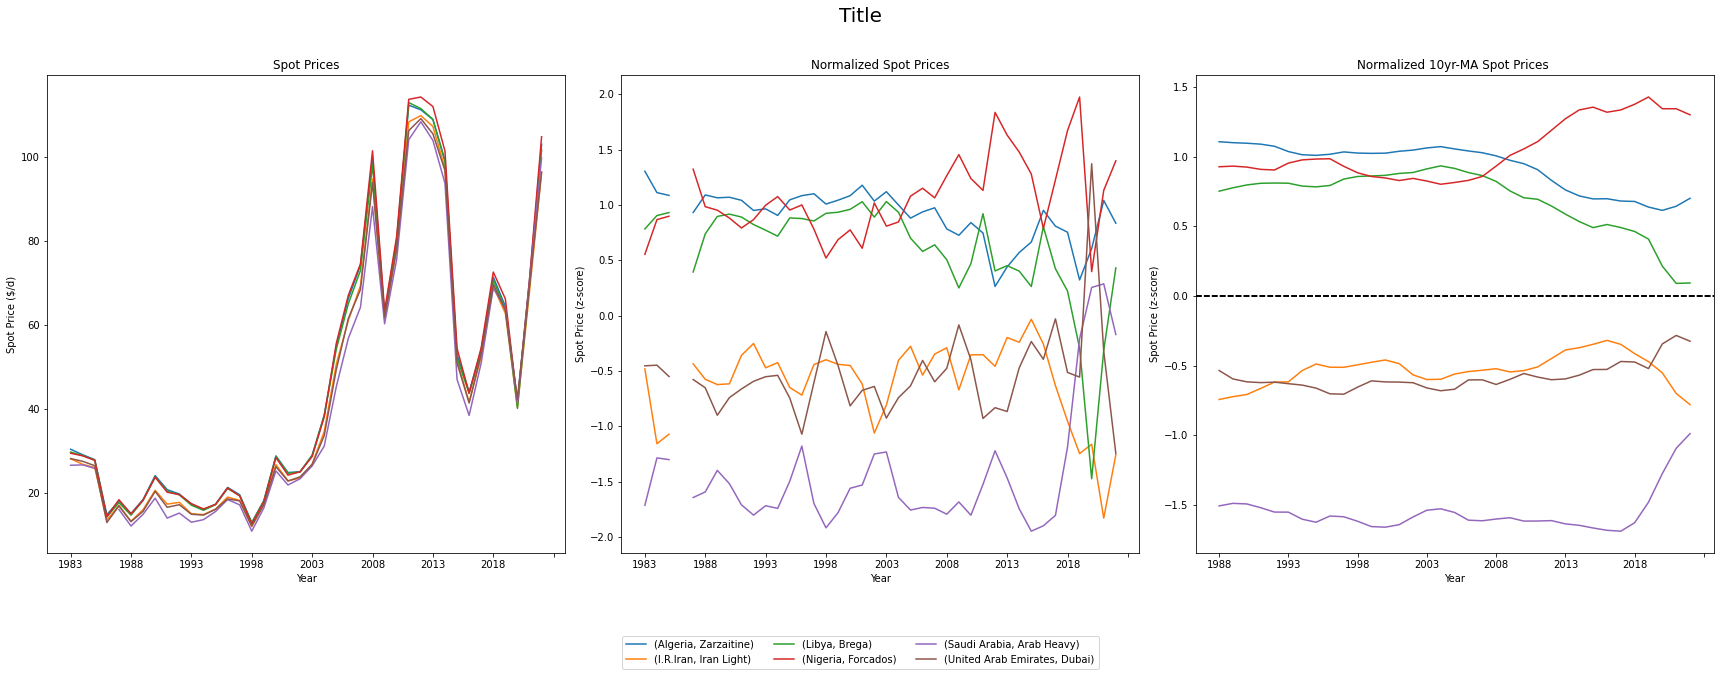

In [36]:
opec_sample_countries = ['Algeria', 'I.R.Iran', 'Libya', 'Nigeria', 'Saudi Arabia', 'United Arab Emirates']
#opec_sample_countries = opec_countries[opec_countries.isin(oil_spot_prices_df.columns)]
price_plot_function(opec_sample_countries, "Title")

In [37]:
# converting python notebook to html
!jupyter nbconvert --to html milestone_2.ipynb --output index

[NbConvertApp] Converting notebook milestone_2.ipynb to html
[NbConvertApp] Writing 1158720 bytes to index.html
